## Credit Card Fraud Detection


Anomaly detection is identifying data points in data that don't fit the normal patterns. 



Use Autoencoder to implement anomaly detection. Build the model by using:

* Pickel-it's the process of converting a Python object into a byte stream to store it in a file/database, maintain program state across sessions, or transport data over the network.
* The scipy. stats contains a large number of statistics, probability distributions functions. 
* The import seaborn portion of the code tells Python to bring the Seaborn library into your current environment.
* You can dynamically change the default rc (runtime configuration) settings in a python script or interactively from the python shell.
* ModelCheckpoint callback is used in conjunction with training using model
* Regularizers allow you to apply penalties on layer parameters or layer activity during optimization.
* Standardize features by removing the mean and scaling to unit variance.
* Matplotlib Inline command is a magic command that makes the plots generated by matplotlib show into the IPython shell that we are running and not in a separate output window

### 1. Import required libraries

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 10, 8


RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

### 2. Upload / access the dataset
Here we are using the credit card dataset to detect fradulent transactions.

Data Exploration

In [ ]:
df = pd.read_csv("/content/creditcard 2.csv")

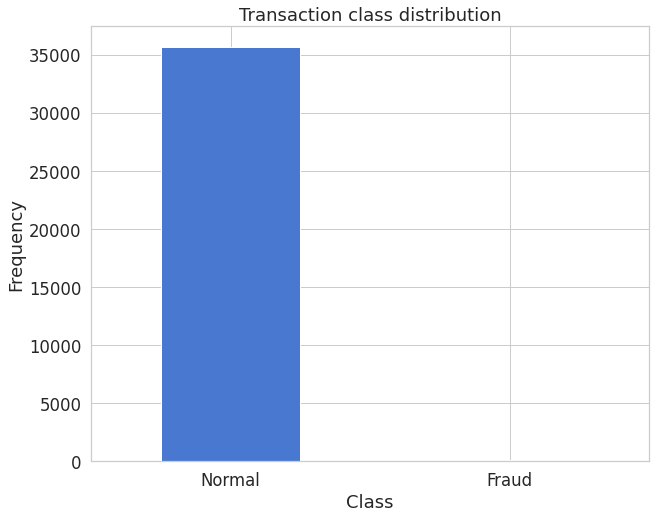

In [ ]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

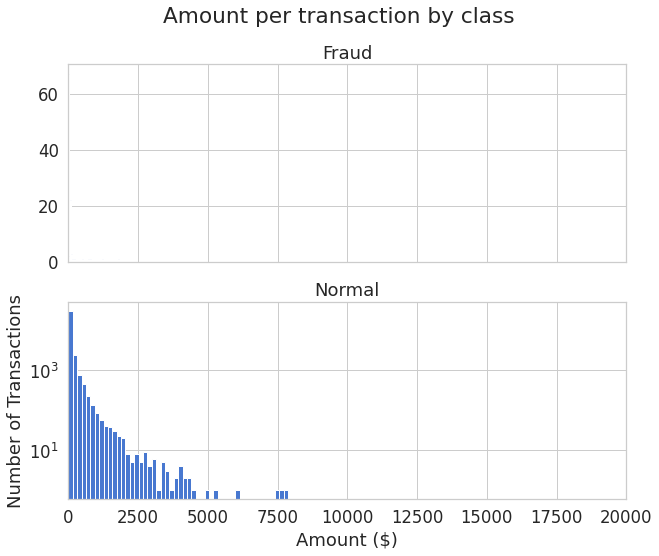

In [ ]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

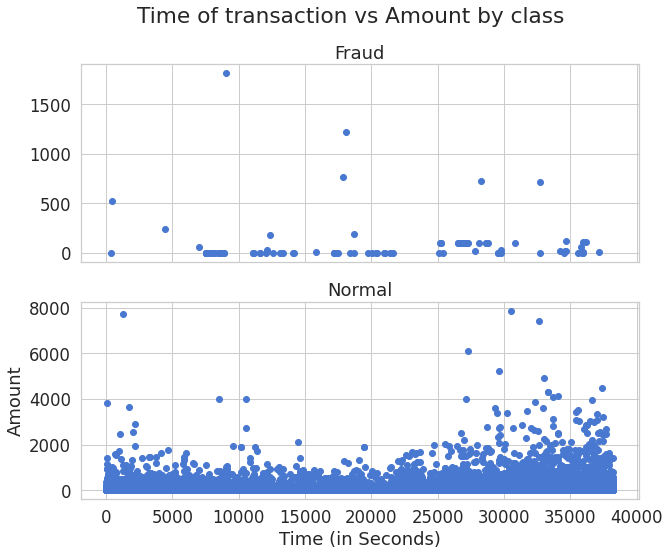

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

Data Preparation

In [ ]:
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(28513, 29)

### 3. Encoder converts it into latent representation
### 4. Decoder networks convert it back to the original input


In [ ]:
input_dim = X_train.shape[1]
encoding_dim = 14
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

### 5. Compile the models with Optimizer, Loss, and Evaluation Metrics

Training

In [ ]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
892/892 [==============================] - 3s 3ms/step - loss: 0.9314 - accuracy: 0.3700 - val_loss: nan - val_accuracy: 0.4734
Epoch 2/100
892/892 [==============================] - 2s 2ms/step - loss: 0.8288 - accuracy: 0.5294 - val_loss: nan - val_accuracy: 0.5581
Epoch 3/100
892/892 [==============================] - 2s 2ms/step - loss: 0.7905 - accuracy: 0.5861 - val_loss: nan - val_accuracy: 0.5942
Epoch 4/100
892/892 [==============================] - 2s 2ms/step - loss: 0.7692 - accuracy: 0.6112 - val_loss: nan - val_accuracy: 0.6088
Epoch 5/100
892/892 [==============================] - 2s 2ms/step - loss: 0.7551 - accuracy: 0.6206 - val_loss: nan - val_accuracy: 0.6148
Epoch 6/100
892/892 [==============================] - 2s 2ms/step - loss: 0.7449 - accuracy: 0.6352 - val_loss: nan - val_accuracy: 0.6304
Epoch 7/100
892/892 [==============================] - 2s 2ms/step - loss: 0.7363 - accuracy: 0.6467 - val_loss: nan - val_accuracy: 0.6408
Epoch 8/100
892/892 

Evaluation

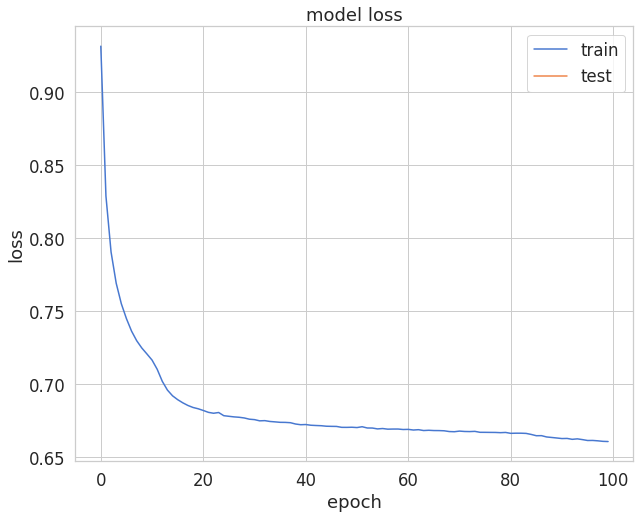

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [ ]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

224/224 [==============================] - 1s 3ms/step


,reconstruction_error,true_class
count,7148.000000,7148.000000
mean,0.836221,0.003218
std,4.408159,0.056637
min,0.036609,0.000000
25%,0.223950,0.000000
50%,0.380775,0.000000
75%,0.605528,0.000000
max,161.650256,1.000000


Reconstruction Error

Reconstruction error without fraud

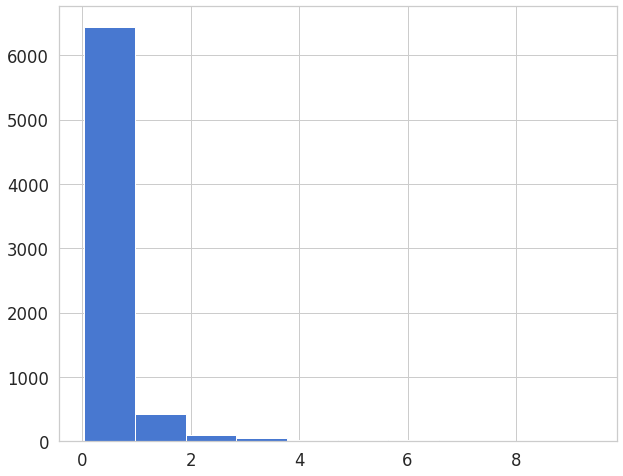

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

Reconstruction error with fraud

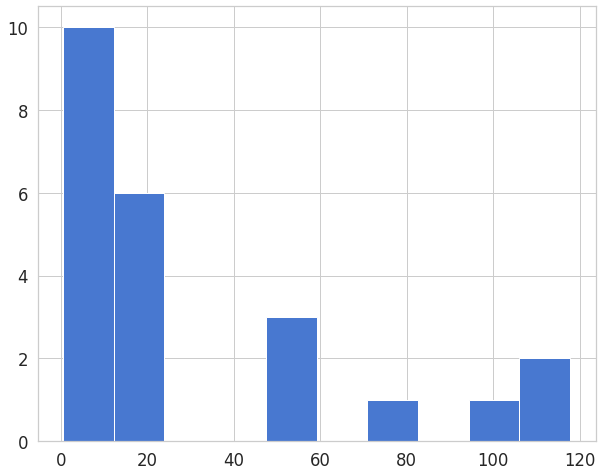

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

.

.

.

.

.

In [ ]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

ValueError: ignored

.

.

.

.

.

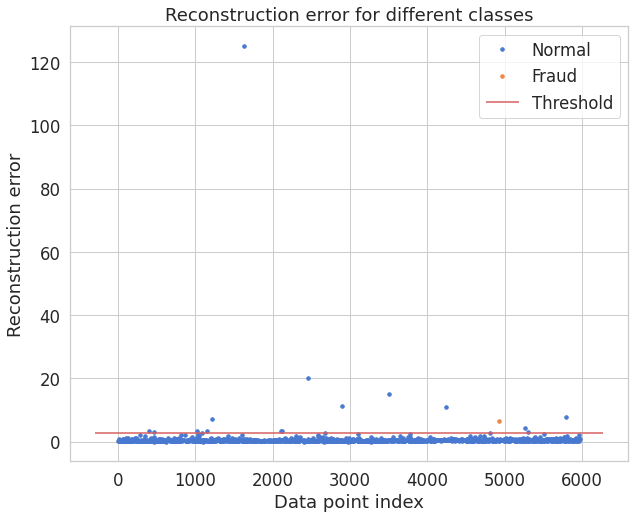

In [ ]:
threshold = 2.9
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

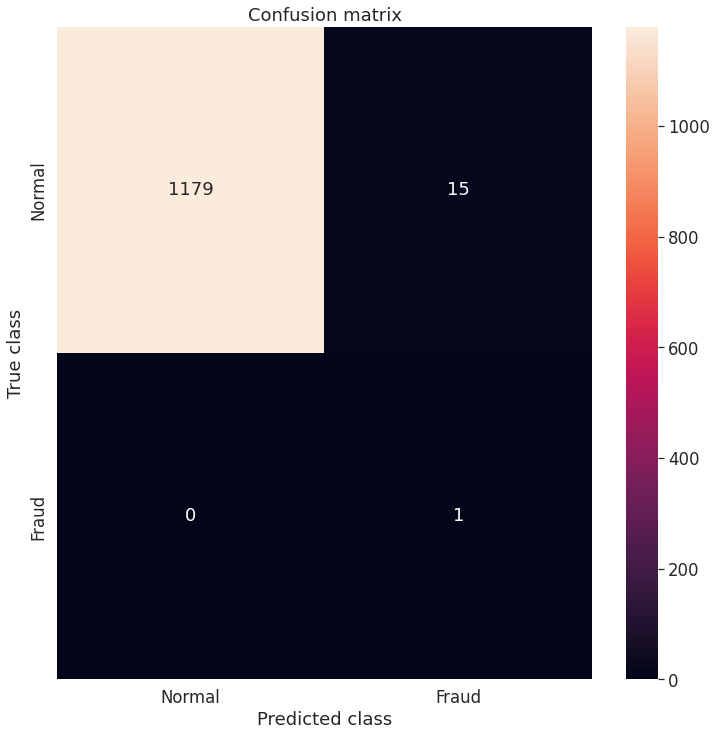

In [ ]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()